In [1]:
import os
import numpy as np
import imageio
import cv2
import matplotlib.pyplot as plt 

face_path = './yalefaces/'
X = []
y_hum = []
y_exp = [] 
#如subject02.centerlight，其y_hum为02，y_exp为centerlight
        
for file in os.listdir(face_path):
    infos = file.split('.')
    hum = infos[0].split('t')[-1]
    ## label starts from 0
    try:
        hum = int(hum) - 1
    except:
        print(hum); break
    exp = infos[1]
    y_hum.append(hum)
    y_exp.append(exp)
    #print(exp)
    ## image
    im_fn = os.path.join(face_path, file)
    gif = imageio.mimread(im_fn)
    gif = gif[0]
    gif = np.array(gif)
    X.append(gif)

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
X = np.array(X)
n_class = max(y_hum) + 1
# ## flatten
# X = X.reshape((X.shape[0], -1))

In [3]:
#分训练集和测试集，构建标签，只作为样例
x_train, x_test, y_train, y_test = train_test_split(X, y_hum, train_size = 0.6, random_state = 0)
y_one_hot = label_binarize(y_test, np.arange(n_class))  

/Users/winston/opt/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


在分类任务中，请注意不要使用太强的分类器，比如SVM。理论上SVM是一个比PCA更高阶的模型。可以不依赖前期的特征正交化来进行分类学习。用来诠释PCA的效果有问题。
本次作业主要要求以下任务任务可以考虑：（基础部分要求前三个必做，后两个可选。）

### 共享的函数

In [ ]:
# def centralize(X):
#     '''中心化'''
#     return X - X.mean(0)

def plot_eigval(D):
    import matplotlib.pyplot as plt 
    
    plt.plot((D/D[0]*100))
    plt.xlabel('No. of eigenvalues')
    plt.ylabel('Magnitude of eigenvalues')
    plt.show()

## PCA

In [ ]:
samples = x_train.copy().reshape((x_train.shape[0], -1))

mean = samples.mean(0)
diff = samples - mean

In [ ]:
diff.shape

In [ ]:
diff @ diff.T

In [ ]:
G

In [ ]:
D, V = np.linalg.eig(G)

n_dim = 20
U = V[:, :n_dim]

In [ ]:
U.shape

In [ ]:
diff[0] @ U @ U.T + mean

In [ ]:
plt.plot(D / D[0] * 100)

In [ ]:
def PCA(A, n_dim=2, show_eigval = False): 
    '''
    对单张图片的列元素（纵向像素）进行PCA
    Input: A ~ m*n
    Output: R ~ m*n
    '''
    G = np.cov(A, rowvar=0)
    D, V = np.linalg.eig(G) 
    
    if show_eigval:
        plot_eigval(D.real)
        
    U = V[:, :n_dim].real
    R = (A @ U @ U.T)
    return R


def PCA_on_sample(X, n_dim=2):
    '''对（已经中心化的）全样本执行PCA
    Input: S ~ d*m*n  Output: R ~ d*m*n'''
    
    x_mean = X.mean(0)
    
    S = X - x_mean
    R = [PCA(A, n_dim) + x_mean for A in S]
    return np.array(R)

In [ ]:
# result1 = PCA_on_sample(x_train, n_dim=20)
# plt.imshow(result1[-1]) ; plt.show()

## 2DPCA

In [89]:
x_train.mean(axis=(1,2))

(98,)

In [419]:
def ICM(S):
    '''compute image covariance matrix 
    for centralized sample S'''
    
    G = np.array([A.T @ A for A in S]).sum(0) 
    return G
    

def PCA2D(X, n_dim=2, show_eigval=False):
#     x_mean = X.mean(0)
#     S = X - x_mean
#     G = ICM(S)
    G = ICM(X) 
        
    D, V = np.linalg.eig(G) 
    if show_eigval:
        plot_eigval(D)
    
    U = V[:, :n_dim] 
    return U


def PCA2D_on_sample(X, n_dim=2, U=None):
#     x_mean = X.mean(0)
#     S = X - x_mean
    
    if U is None:
        U = PCA2D(X, n_dim=n_dim) 
        
#     R = [A @ U @ U.T + x_mean for A in S]
    R = [A @ U @ U.T for A in X]
    return np.array(R)

In [422]:
result2 = PCA2D_on_sample(x_train, n_dim=50)

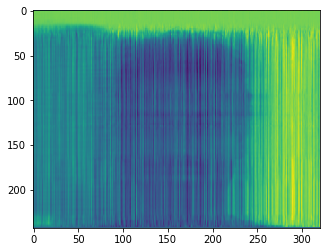

In [423]:
plt.imshow(result2[-1]); plt.show()

## L1 Norm 2DPCA

In [99]:
def initialize_u(w):
    tmp = np.ones(w)
    U = tmp / np.linalg.norm(tmp, ord=2)
    return U

def compute_u(X, U):
    delta = 1
    while np.abs(delta) > 0:
        Y = X @ U  #98*243
        P = (Y > 0) * 2 + -1  #98*243

        tmp = (P.T * X.T).T.sum(0).sum(0)
        U = tmp / np.linalg.norm(tmp) 

        delta = np.linalg.norm(X @ U, ord=1) - np.linalg.norm(Y, ord=1)
    return U

def update_x(x, u):
    r = x - (x @ u).reshape(x.shape[0], -1, 1) @ u.reshape(1,-1)
    return(r)

def PCA2D_L1(S, n_dim=5):
    R = [] 
    w = S.shape[-1]
    U0 = initialize_u(w) 
    
    X = S 
    U = compute_u(X, U0)
    R.append(U) 
    
    for i in range(n_dim - 1):
        X = update_x(X, U)
        U = compute_u(X, U0)
        R.append(U)
        
    return np.array(R).T

def PCA2D_L1_on_sample(X, n_dim=5, U=None):
#     x_mean = X.mean(0)
#     S = X - x_mean
    if U is None:
        U = PCA2D_L1(S, n_dim) 
#     R = [s @ U @ U.T + x_mean for s in S]
    R = [s @ U @ U.T + x_mean for s in X]
    return np.array(R)

In [100]:
# result3 = PCA2D_L1_on_sample(x_train, n_dim=20)

In [101]:
# plt.imshow(result3[-1]); plt.show()

---
* 样本分布可视化对比

In [361]:
# S = x_train - x_train.mean(0)
# S = x_train
# A = S[-1]

U2 = PCA2D(x_train, n_dim=50)
U3 = PCA2D_L1(x_train, n_dim=50)

### Reconstructed subimages with 2DPCA & 2DPCA-L1

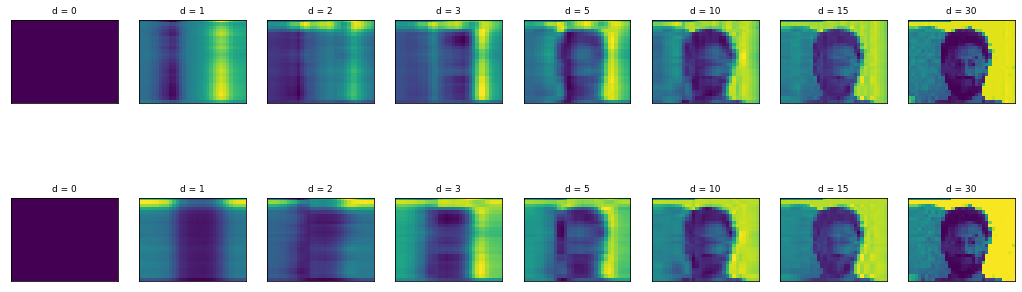

In [352]:
A = x_train[:, ::pace, ::pace][-1]

#画图
n_row = 2
n_col = 8
tap = [0,1,2,3,5,10,15,30]

# Plot the first 12 eignenvalues
plt.figure(figsize=(18,6))
for i in list(range(n_col)):
    plt.subplot(n_row, n_col, i + 1)
    u = U2[:, :tap[i]]
    plt.imshow((A @ u).reshape(A.shape[0], -1) @ u.T.reshape(-1,A.shape[1]))
    title_text = 'd = ' + str(tap[i])
    plt.title(title_text, size=9)
    plt.xticks(())
    plt.yticks(())
for i in list(range(n_col)):
    plt.subplot(n_row, n_col, i + 1 + n_col)
    u = U3[:, :tap[i]]
    plt.imshow((A @ u).reshape(A.shape[0], -1) @ u.T.reshape(-1,A.shape[1]))
    title_text = 'd = ' + str(tap[i])
    plt.title(title_text, size=9)
    plt.xticks(())
    plt.yticks(())
plt.show()

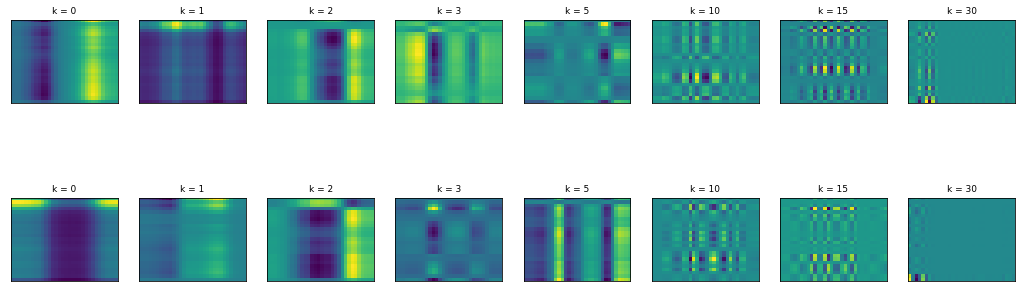

In [353]:
#画图
n_row = 2
n_col = 8
tap = [0,1,2,3,5,10,15,30]

# Plot the first 12 eignenvalues
plt.figure(figsize=(18,6))
for i in list(range(n_col)):
    plt.subplot(n_row, n_col, i + 1)
    u = U2[:, tap[i]]
    plt.imshow((A @ u).reshape(A.shape[0], -1) @ u.T.reshape(-1,A.shape[1]))
    title_text = 'k = ' + str(tap[i])
    plt.title(title_text, size=9)
    plt.xticks(())
    plt.yticks(())
for i in list(range(n_col)):
    plt.subplot(n_row, n_col, i + 1 + n_col)
    u = U3[:, tap[i]]
    plt.imshow((A @ u).reshape(A.shape[0], -1) @ u.T.reshape(-1,A.shape[1]))
    title_text = 'k = ' + str(tap[i])
    plt.title(title_text, size=9)
    plt.xticks(())
    plt.yticks(())
plt.show()

* 聚类算法效果对比（可以不限于k-means，请计算召回率/准确率/F值作为定量指标）


* 分类对比（可以使用KNN、朴素贝叶斯等分类器）

## Classification Method

- Define the distance btw. two arbitrary feature matrices, $B_{i} = \left[  Y_{1}^{(i)}, Y_{2}^{(i)}, \dots , Y_{d}^{(i)}  \right]$ and $B_{j} = \left[  Y_{1}^{(j)}, Y_{2}^{(j)}, \dots , Y_{d}^{(j)}  \right]$, as
$$
d(B_{i}, B_{j}) = \sum_{k=1}^{d}{\left|\left|Y_{k}^{(i)} - Y_{k}^{(j)}\right|\right|_{2} },
$$
where $\left|\left|Y_{k}^{(i)} - Y_{k}^{(j)}\right|\right|_{2}$ denotes the Euclidean distance btw. the two principal component vectors $Y_{k}^{(i)}$ and $Y_{k}^{(j)}$

- The training samples are $B_1, B_2, \dots, B_M$ from `x_train`. Each of these samples is assigned a given class $\omega_{k}$ from `y_train`.
- Given a test sample $B$ from `x_test`, if $d(B, B_{l}) = \min_{j}{d(B, B_{j})}$ and $B_{l} \in \omega_{k}$, then the resulting decision is $B \in \omega_{k}$


In [413]:
diff = (x_train @ U2) - (x_test @ U2)[-1]

tmp1 = np.array([np.linalg.norm(x, axis=0).sum() for x in diff])

In [414]:
tmp2 = np.array([np.sum([np.linalg.norm(x @ u - x_test[-1] @ u) for u in U2.T]) for x in x_train])

In [418]:
np.round(tmp1 - tmp2,10)

array([ 0.,  0.,  0., -0., -0., -0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
       -0.,  0.,  0.,  0.,  0.,  0., -0.,  0.,  0., -0.,  0., -0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0., -0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0., -0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0., -0.,  0.,  0.,  0., -0.,  0.,
        0.,  0., -0., -0.,  0.,  0.,  0.,  0.,  0., -0.,  0.,  0.,  0.,
        0., -0.,  0.,  0.,  0., -0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0., -0.,  0.,  0.,  0.,  0.,  0.])

In [406]:
y_train[81], y_test[-1]

(13, 13)

### 分类准确性

依次取前 1..50 个维数的投影向量(projection vectors)提取原图像的特征，计算预测集和训练集特征量的“距离”（定义见上）

In [358]:
def acc_cpt(U_mat, x_train, x_test, y_train, y_test, n_dim=None):
    res = []
    if n_dim is None:
        n_dim = U_mat.shape[1]
    U = U_mat[:,:n_dim].copy()
    for i_test in range(len(x_test)):
        diff = (x_train @ U) - (x_test @ U)[i_test]

        i_train = np.argmin([np.linalg.norm(x, axis=0).sum() for x in diff])

        res.append(y_test[i_test] == y_train[i_train])

#         if i_test % 5 == 0:
#             print(f'x_test {i_test} FINISHED')

    return res

In [193]:
# acc_res_3 = {}
# for i in range(50):
#     acc = acc_cpt(U3, x_train, x_test, y_train, y_test, i)
#     acc_res_3[i] = acc
#     print(f"FINISHED n_dim = {i}")

FINISHED n_dim = 0
FINISHED n_dim = 1
FINISHED n_dim = 2
FINISHED n_dim = 3
FINISHED n_dim = 4
FINISHED n_dim = 5
FINISHED n_dim = 6
FINISHED n_dim = 7
FINISHED n_dim = 8
FINISHED n_dim = 9
FINISHED n_dim = 10
FINISHED n_dim = 11
FINISHED n_dim = 12
FINISHED n_dim = 13
FINISHED n_dim = 14
FINISHED n_dim = 15
FINISHED n_dim = 16
FINISHED n_dim = 17
FINISHED n_dim = 18
FINISHED n_dim = 19
FINISHED n_dim = 20
FINISHED n_dim = 21
FINISHED n_dim = 22
FINISHED n_dim = 23
FINISHED n_dim = 24
FINISHED n_dim = 25
FINISHED n_dim = 26
FINISHED n_dim = 27
FINISHED n_dim = 28
FINISHED n_dim = 29
FINISHED n_dim = 30
FINISHED n_dim = 31
FINISHED n_dim = 32
FINISHED n_dim = 33
FINISHED n_dim = 34
FINISHED n_dim = 35
FINISHED n_dim = 36
FINISHED n_dim = 37
FINISHED n_dim = 38
FINISHED n_dim = 39
FINISHED n_dim = 40
FINISHED n_dim = 41
FINISHED n_dim = 42
FINISHED n_dim = 43
FINISHED n_dim = 44
FINISHED n_dim = 45
FINISHED n_dim = 46
FINISHED n_dim = 47
FINISHED n_dim = 48
FINISHED n_dim = 49


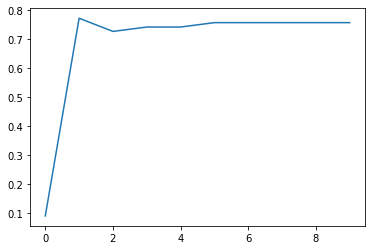

In [226]:
import pandas as pd 
plt.plot(pd.DataFrame(acc_res_3).mean().iloc[:10])
plt.show()

## 发现，由于宽243所保留的信息过多，实现分类过于容易，因此对图片进行压缩

In [229]:
x_train.shape, U3.shape

((98, 243, 320), (320, 50))

In [236]:
x_train[:,::5,::5].shape, U3[::5,:].shape

((98, 49, 64), (64, 50))

## 选取步长 pace

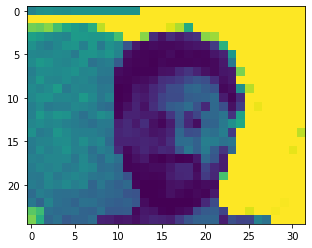

In [354]:
pace = 10
plt.imshow(x_train[-1,::pace,::pace]); plt.show()

In [356]:
pace = 10
acc_res_3 = {}
for i in range(0,50,5):
    acc = acc_cpt(U3, x_train[:,::pace,::pace], x_test[:,::pace,::pace], y_train, y_test, i)
    acc_res_3[i] = acc
    print(f"FINISHED n_dim = {i}")

FINISHED n_dim = 0
FINISHED n_dim = 5
FINISHED n_dim = 10
FINISHED n_dim = 15
FINISHED n_dim = 20
FINISHED n_dim = 25
FINISHED n_dim = 30
FINISHED n_dim = 35
FINISHED n_dim = 40
FINISHED n_dim = 45


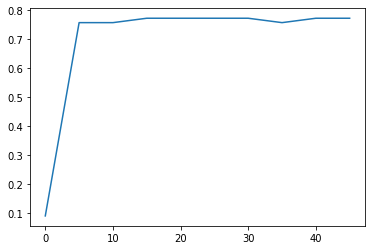

In [357]:
import pandas as pd 
plt.plot(pd.DataFrame(acc_res_3).mean().iloc[:100])
plt.show()

In [260]:
U3[::pace,:].shape

(32, 50)

---

In [151]:
res2 = []
for i_test in range(len(x_test)):
    diff = (x_train @ U2) - (x_test @ U2)[i_test]

    i_train = np.argmin([np.linalg.norm(x, axis=0).sum() for x in diff])
    
    res2.append(y_test[i_test] == y_train[i_train])
    
    if i_test % 5 == 0:
        print(f'x_test {i_test} FINISHED')
        
np.sum(res) / len(res)

x_test 0 FINISHED
x_test 5 FINISHED
x_test 10 FINISHED
x_test 15 FINISHED
x_test 20 FINISHED
x_test 25 FINISHED
x_test 30 FINISHED
x_test 35 FINISHED
x_test 40 FINISHED
x_test 45 FINISHED
x_test 50 FINISHED
x_test 55 FINISHED
x_test 60 FINISHED
x_test 65 FINISHED


In [177]:
res3 = []
for i_test in range(len(x_test)):
    diff = (x_train @ U3) - (x_test @ U3)[i_test]

    i_train = np.argmin([np.linalg.norm(x, axis=0).sum() for x in diff])
#     i_train = np.argmin(np.linalg.norm(diff,axis=(1,2))) wrong way
    
    res3.append(y_test[i_test] == y_train[i_train])
    
    if i_test % 5 == 0:
        print(f'x_test {i_test} FINISHED')

np.sum(res3) / len(res3)

x_test 0 FINISHED
x_test 5 FINISHED
x_test 10 FINISHED
x_test 15 FINISHED
x_test 20 FINISHED
x_test 25 FINISHED
x_test 30 FINISHED
x_test 35 FINISHED
x_test 40 FINISHED
x_test 45 FINISHED
x_test 50 FINISHED
x_test 55 FINISHED
x_test 60 FINISHED
x_test 65 FINISHED


0.7575757575757576

## PCA2D 和 2DL1 无差别

* 个案效果对比分析讨论（可选）

* 其他深入讨论与模型理解探讨（可选）

请把内容（除了给的数据集，但如果用到自己造的数据或者新的数据集的话请一并打包）打包为压缩文件，命名为Image-pca-学号-姓名上传。
作业截止时间：29号。如果希望在课堂上进行交流，请在26号前提交。被邀请课堂交流的同学会有额外5%加分（不受20%上限约束）。延期提交（最高90分，可加分）时间5月6号。5月6号后提交的最高80分，不再有加分项。

---

报告：PCA 2DPCA L1Norm2DPCA 在不同类型数据下的优劣势

PCA：


2DPCA的主要优势：

1. 更精确：可以精确地计算出协方差矩阵
2. 效率高：协方差矩阵维数较小，缩短了计算特征值和特征向量的时间
> 若图像的大小为 $d = h \times w$，对PCA而言，协方差矩阵大小为 $d \times d$，但是对于2DPCA而言，协方差矩阵大小为 $w \times w$

2DPCA-L1的主要优势：

1. 由于使用了 L1-norm-based matric，对离群值 (outliers) 的鲁棒性 (robustness) 好
2. 由于使用了二维的表示形式，减少了原始图像信息的损失
3. 避免了大量的奇异值计算，迭代过程比较简单

